# Local weather's impact on traffic accident rate
A case study in Milwaukee.

### Target data
Since we are looking to see the impact of weather on car accident rates, we will be using data provided by the Milwaukee police on their website [that can be found here](https://data.milwaukee.gov/dataset/trafficaccident/resource/8fffaa3a-b500-4561-8898-78a424bdacee). This data consists of four columns:
* Row Number
* Case ID
* Date and time of the accident
* Location of the accident

All fields come from police reports. There are a few restrictions; this data does not include accidents if all of the following are true:
1. Accident did not result in injury or death
2. Accident did not damage government-owned non-vehicle property to an apparent extent of $200 or more

3. Accident did not result in total damage to property owned by any one person to an apparent extent of $1000 or more.


Therefore, minor accidents are not reported in this dataset.

In [429]:
# jupyter extentions
%load_ext autoreload
%autoreload 2

# imports
import calendar as cal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

TARGET_DATA_PATH = './data/trafficaccident.csv'
WEATHER_DATA_PATH = './data/weatherdata.csv'

# import utilities
import utils

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [430]:
# load up the data, and re-type the date column
initial_traffic_df = pd.read_csv(TARGET_DATA_PATH)
initial_traffic_df['CASEDATE'] = pd.to_datetime(initial_traffic_df['CASEDATE'])
initial_traffic_df.dtypes
initial_traffic_df.head()

CASENUMBER             object
CASEDATE       datetime64[ns]
ACCIDENTLOC            object
dtype: object

,CASENUMBER,CASEDATE,ACCIDENTLOC
0,J9L010TWVP,2019-11-10 19:08:00,N BREMEN ST & E LOCUST ST
1,J9L0MJDN3M,2019-11-10 18:24:00,N 27TH ST & W VLIET ST
2,J9L072BC6N,2019-11-10 16:59:00,On Highway EE at Highway CON
3,J9L07X84PZ,2019-11-10 16:44:00,S 21ST ST & W GREENFIELD AV
4,J9L072BC6M,2019-11-10 16:25:00,N 51ST BL & W SILVER SPRING DR


Off the bat, we can assume that the data is organized by case date with the most recent first. Additionally (and perhaps more importantly) the accident location is only documented through crossing streets; were we want to identify more granular weather patterns than just *in Milwaukee* geocoding these would prove quite the challenge. Let's dig in and get more of a feel for the data, especially the date information.

In [431]:
# shape of the frame, min and max days (beginning and end of the data set), number of unique locations
initial_traffic_df.shape
initial_traffic_df['CASEDATE'].min()
initial_traffic_df['CASEDATE'].max()
initial_traffic_df['ACCIDENTLOC'].nunique()
initial_traffic_df.describe(include="all")

(154743, 3)

Timestamp('2006-06-27 12:12:00')

Timestamp('2019-11-10 19:08:00')

82398

,CASENUMBER,CASEDATE,ACCIDENTLOC
count,154743,154738,154743
unique,154733,146925,82398
top,J9L0CGFB0G,2016-03-24 18:00:00,Address not entered
freq,2,6,709
first,NaN,2006-06-27 12:12:00,NaN
last,NaN,2019-11-10 19:08:00,NaN


## Initial Data Cleaning
There are a few discrepancies in the data set that I would like to correct off the bat:
* CASENUMBER should be unique; therefore, the fact that there is one with 2 entries is an error.
* As you can see by the counts, there are 5 cases without a date. Those are useless to us.

In [432]:
# drop duplicates
traffic_df = initial_traffic_df.drop_duplicates(subset='CASENUMBER')

# drop nulls from CASEDATE
traffic_df = traffic_df.dropna()

initial_traffic_df.shape
traffic_df.shape

(154743, 3)

(154732, 3)

## Date analysis
Since we will eventually be linking this to weather data, it's especially important that the datetime data is clean. To that end, let's get a feel for the distribution across the years, months, etc. Additionally, this will give us insight into what granularity is appropriate for our analysis.

In [433]:
traffic_df['CASEDATE_YEAR'] = traffic_df['CASEDATE'].dt.year
traffic_df['CASEDATE_MONTH'] = traffic_df['CASEDATE'].dt.month
traffic_df['CASEDATE_DAY'] = traffic_df['CASEDATE'].dt.day

# add an option for a more readable month
traffic_df['CASEDATE_MONTH_ABBR'] = np.vectorize(utils.convert_month_to_abbr)(traffic_df['CASEDATE_MONTH'])
traffic_df['CASEDATE_MONTH_ABBR'] = traffic_df['CASEDATE_MONTH_ABBR'] + ' ' + traffic_df['CASEDATE_YEAR'].astype('str')
traffic_df.head()

,CASENUMBER,CASEDATE,ACCIDENTLOC,CASEDATE_YEAR,CASEDATE_MONTH,CASEDATE_DAY,CASEDATE_MONTH_ABBR
0,J9L010TWVP,2019-11-10 19:08:00,N BREMEN ST & E LOCUST ST,2019,11,10,Nov 2019
1,J9L0MJDN3M,2019-11-10 18:24:00,N 27TH ST & W VLIET ST,2019,11,10,Nov 2019
2,J9L072BC6N,2019-11-10 16:59:00,On Highway EE at Highway CON,2019,11,10,Nov 2019
3,J9L07X84PZ,2019-11-10 16:44:00,S 21ST ST & W GREENFIELD AV,2019,11,10,Nov 2019
4,J9L072BC6M,2019-11-10 16:25:00,N 51ST BL & W SILVER SPRING DR,2019,11,10,Nov 2019


## Accidents per year
Let's take a look at the number of accidents per year that we have in the dataset.

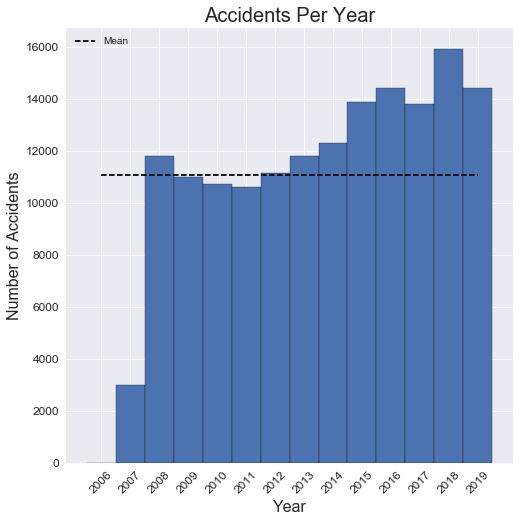

In [434]:
# plot number of accidents per year
year_val_counts = traffic_df['CASEDATE_YEAR'].value_counts()
utils.plot_time_hist(year_val_counts, 'Accidents Per Year', xlabel='Year', ylabel='Number of Accidents')
plt.show()

Right away, we can see that 2006 and 2007 have an extremely low amount of data; these seem like outliers. First, let's view those in 2006 and a few from 2007.

In [435]:
potential_outliers = traffic_df[traffic_df['CASEDATE_YEAR'].isin([2006, 2007])].sort_values(by='CASEDATE')
potential_outliers.shape
potential_outliers

(3001, 7)

,CASENUMBER,CASEDATE,ACCIDENTLOC,CASEDATE_YEAR,CASEDATE_MONTH,CASEDATE_DAY,CASEDATE_MONTH_ABBR
154737,9H0BDN8,2006-06-27 12:12:00,2730 N 27TH ST - 100 Feet N of W CENTER ST on ...,2006,6,27,Jun 2006
154736,9H1WSVF,2006-09-26 08:30:00,2619 N 20TH ST - 450 Feet S of W CENTER ST on ...,2006,9,26,Sep 2006
154735,9GW8K60,2007-02-02 10:05:00,S 70TH ST & W KEARNEY ST,2007,2,2,Feb 2007
154734,9GW8K61,2007-02-02 13:39:00,2210 W VLIET ST - 30 Feet W of N 22ND ST on W ...,2007,2,2,Feb 2007
154733,9GW8K63,2007-02-05 14:01:00,1523 N 39TH ST,2007,2,5,Feb 2007
154732,9GW8K65,2007-02-08 00:00:00,5028 N 66TH ST - 175 Feet S of W LANCASTER AV ...,2007,2,8,Feb 2007
154731,9GW8K66,2007-02-09 10:39:00,W CYPRESS ST & W FOND DU LAC AV,2007,2,9,Feb 2007
154730,9GW8K67,2007-02-22 07:29:00,N 51ST ST & W LISBON AV - 10 Feet S of N 51ST ...,2007,2,22,Feb 2007
154729,9GW8K68,2007-02-23 07:27:00,S HAWLEY RD & W MAIN ST,2007,2,23,Feb 2007
154728,9GW8K69,2007-02-23 08:55:00,Location not reported,2007,2,23,Feb 2007


Two from 2006 and ~3000 from 2007 (compared to >10,000 in the other years). I'm comfortable taking these out of the data set. On the note of data cleaning, since 2019 isn't complete yet I will take that out of the data set as well.

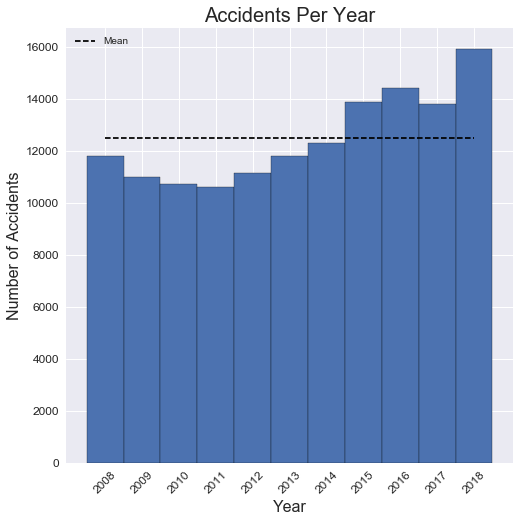

In [436]:
pruned_traffic_df = traffic_df[~traffic_df['CASEDATE_YEAR'].isin([2006, 2007, 2019])]
year_val_counts = pruned_traffic_df['CASEDATE_YEAR'].value_counts()
utils.plot_time_hist(year_val_counts, 'Accidents Per Year', xlabel='Year', ylabel='Number of Accidents')
plt.show()

With our cleaned data, we can see a fairly clear upward trend over the past 10 years; there have been more accidents happening each year. This could be due to a multitude of reasons -- increased population, more interference from technology, or increased construction. I won't pretend to identify a true reason here, so for now we can accept that there has been an upward trend. 

## Accidents per month
While looking over the years can identify a long term trend, weather typically runs in cycles through the year. So, let's get a bit more granular within a year and take a look at the number of accidents per month in a 3 year period.

In [437]:
month_analysis_df = pruned_traffic_df[pruned_traffic_df['CASEDATE_YEAR'].isin([2016, 2017, 2018])]
month_analysis_df.shape

(44107, 7)

In [438]:
# keeping the order right requires some manipulation, and we want to pass the readable labels to the graph
grouped = month_analysis_df.groupby(['CASEDATE_YEAR', 'CASEDATE_MONTH'])
month_counts = grouped.size().reset_index()

month_counts['CASEDATE_MONTH_ABBR'] = np.vectorize(utils.convert_month_to_abbr)(month_counts['CASEDATE_MONTH'])
month_counts['CASEDATE_MONTH_ABBR'] = month_counts['CASEDATE_MONTH_ABBR'] + ' ' + month_counts['CASEDATE_YEAR'].astype(str)
month_counts.head()

,CASEDATE_YEAR,CASEDATE_MONTH,0,CASEDATE_MONTH_ABBR
0,2016,1,1352,Jan 2016
1,2016,2,1164,Feb 2016
2,2016,3,1277,Mar 2016
3,2016,4,1148,Apr 2016
4,2016,5,1254,May 2016


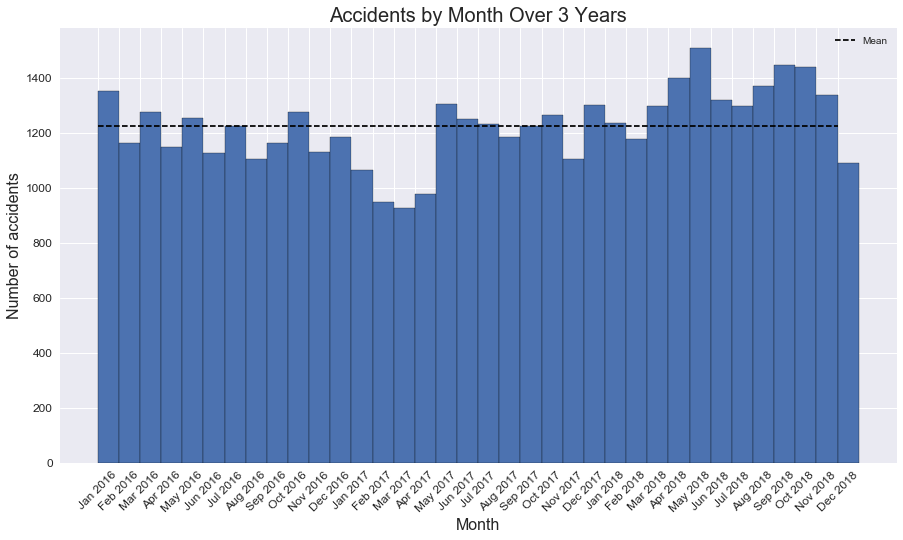

In [439]:
vc_series = pd.Series(index=month_counts['CASEDATE_MONTH_ABBR'], data=month_counts[0].values)
utils.plot_time_hist(vc_series,
                     'Accidents by Month Over 3 Years',
                     xlabel='Month',
                     ylabel='Number of accidents',
                     figsize=(15, 8),
                     align='edge')
plt.show()

I don't see any obvious trends here, so let's compare each month with it's counterpart in the past 3 years.

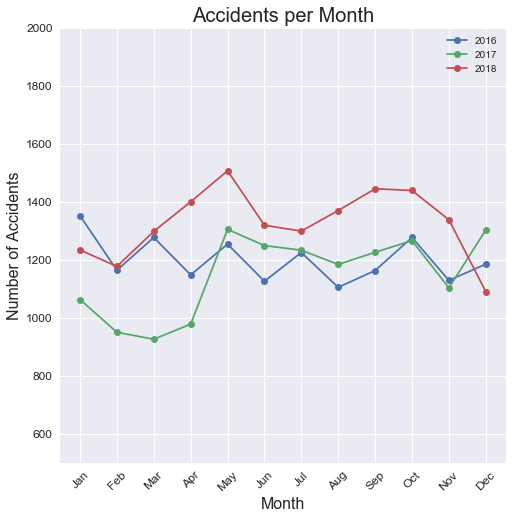

In [440]:
month_counts_2016 = month_counts[month_counts['CASEDATE_YEAR'] == 2016]
vc_2016 = pd.Series(index=month_counts_2016['CASEDATE_MONTH'], data=month_counts_2016[0].values)

month_counts_2017 = month_counts[month_counts['CASEDATE_YEAR'] == 2017]
vc_2017 = pd.Series(index=month_counts_2017['CASEDATE_MONTH'], data=month_counts_2017[0].values)

month_counts_2018 = month_counts[month_counts['CASEDATE_YEAR'] == 2018]
vc_2018 = pd.Series(index=month_counts_2018['CASEDATE_MONTH'], data=month_counts_2018[0].values)

years = [(2016, vc_2016), (2017, vc_2017), (2018, vc_2018)]
utils.plot_months_side_by_side(years, 'Accidents per Month', xlabel='Month', ylabel='Number of Accidents')
plt.show()

Counter to intuition, it looks like there are a lower amount of reported accidents in the winter months than the rest of the year. This should give us something to look for later on when comparing to the weather. Just for fun, let's plot the years by day and see what happens.

In [441]:
grouped_day = month_analysis_df.groupby(['CASEDATE_YEAR', 'CASEDATE_MONTH', 'CASEDATE_DAY'])
day_counts = grouped_day.size().reset_index()

# sortable date identifier for easy plotting
day_counts['IDENTIFIER'] = day_counts['CASEDATE_YEAR'].astype('str') + \
    day_counts['CASEDATE_MONTH'].astype('str').str.pad(2, fillchar='0') + \
    day_counts['CASEDATE_DAY'].astype('str').str.pad(2, fillchar='0')
    
day_counts.head()

,CASEDATE_YEAR,CASEDATE_MONTH,CASEDATE_DAY,0,IDENTIFIER
0,2016,1,1,54,20160101
1,2016,1,2,43,20160102
2,2016,1,3,43,20160103
3,2016,1,4,49,20160104
4,2016,1,5,50,20160105


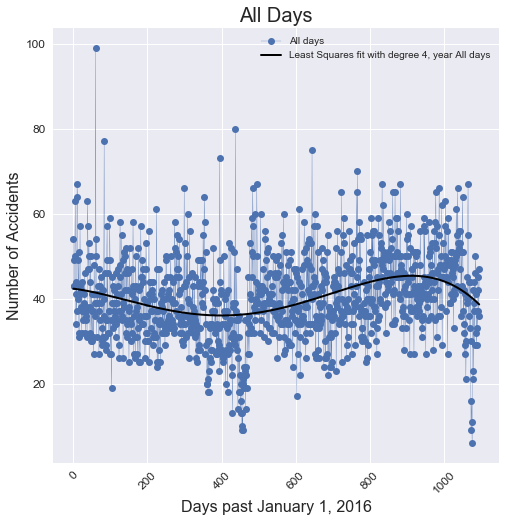

In [442]:
vc_all_days = pd.Series(index=day_counts['IDENTIFIER'], data=day_counts[0].values)
utils.plot_days([('All days', vc_all_days)], 'All Days', linestyle=None, 
                marker='o', linewidth=.3, fit_trendline=True, deg=4,
                xlabel='Days past January 1, 2016', ylabel='Number of Accidents',
                override_fit_color='black')
plt.show()

Aside from some outliers, this graph isn't incredibly interesting; the least squares fit shows variation between years but not a ton. Let's compare the years by day on top of each other.

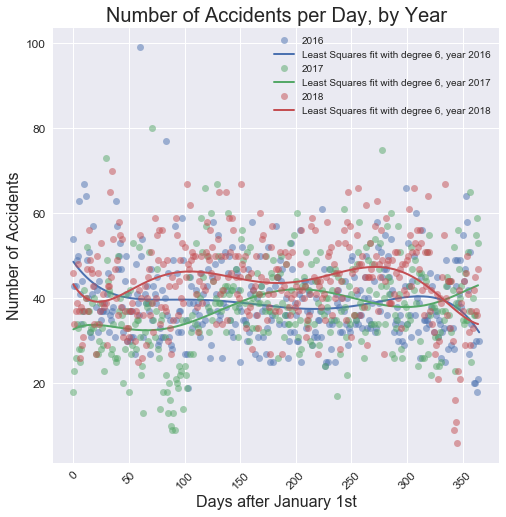

In [443]:
day_counts_2016 = day_counts[day_counts['CASEDATE_YEAR'] == 2016]
day_counts_2017 = day_counts[day_counts['CASEDATE_YEAR'] == 2017]
day_counts_2018 = day_counts[day_counts['CASEDATE_YEAR'] == 2018]

vc_days_2016 = pd.Series(index=day_counts_2016['IDENTIFIER'], data=day_counts_2016[0].values)
vc_days_2017 = pd.Series(index=day_counts_2017['IDENTIFIER'], data=day_counts_2017[0].values)
vc_days_2018 = pd.Series(index=day_counts_2018['IDENTIFIER'], data=day_counts_2018[0].values)

year_list = [('2016', vc_days_2016), ('2017', vc_days_2017), ('2018', vc_days_2018)]

utils.plot_days(year_list, 'Number of Accidents per Day, by Year',
                linewidth=0, marker='o', alpha=.5, fit_trendline=True, deg=6,
                xlabel='Days after January 1st', ylabel='Number of Accidents')
plt.show()

In 2017 and 2018, it looks like there might be a bit of seasonality; the level of it is suspect though. Either way, I think we have spent enough time on the target -- let's dive into the weather data.

## Weather Data
In order to investigate the correlation between number of traffic accidents and the weather, we need to be able to get the weather on the day of the accident. To that end, I have downloaded a dataset of daily weather summaries from the National Oceanic and Atmospheric Administration. This data includes a wide variety of information about the weather around Milwaukee including precipitation, snowfall, etc. More information about the dataset can be found in [its documentation](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf) as well as the [NOAA website](https://www.ncdc.noaa.gov/cdo-web/datasets#GHCND)

The data has a fairly standard structure; it gives the station where the data was collected, the location of the station, the day of the summary, and a few characteristics about the weather that day. We are specifically interested in the PRCP and SNOW column; these gives the total precipitation for the day.

While we have the exact location of the station where the data was taken, we have no idea how it relates to each of the crashes. In an ideal world, we could geocode the crashes and get accurate data, but that is out of scope of this project. For now, we will use the West Allis station since it was deemed closest to the center of Milwaukee through observation.

In [444]:
init_weather_df = pd.read_csv(WEATHER_DATA_PATH)
init_weather_df.shape
init_weather_df.columns
init_weather_df.head()

(83591, 29)

Index(['STATION', 'NAME', 'DATE', 'AWND', 'DAPR', 'MDPR', 'PGTM', 'PRCP',
       'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WDF2', 'WDF5', 'WESD',
       'WESF', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06',
       'WT08', 'WT09', 'WT11'],
      dtype='object')

,STATION,NAME,DATE,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
0,USC00473391,"HALES CORNERS WHITNALL PK, WI US",2016-01-01,NaN,NaN,NaN,NaN,0.0,0.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00473391,"HALES CORNERS WHITNALL PK, WI US",2016-01-02,NaN,NaN,NaN,NaN,0.0,0.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00473391,"HALES CORNERS WHITNALL PK, WI US",2016-01-03,NaN,NaN,NaN,NaN,0.0,0.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00473391,"HALES CORNERS WHITNALL PK, WI US",2016-01-04,NaN,NaN,NaN,NaN,0.0,0.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00473391,"HALES CORNERS WHITNALL PK, WI US",2016-01-05,NaN,NaN,NaN,NaN,0.0,0.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [445]:
# right off the bat, filter down to the station we care about
weather_df = init_weather_df[init_weather_df['STATION'] == 'US1WIMW0018'] # West Allis Station
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

# restrict the days to the days we considered above
weather_df = weather_df[weather_df['DATE'] < '2019-01-01']

/Users/tstuessi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [446]:
weather_df.shape
weather_df[['PRCP', 'SNOW']].describe()

(1029, 29)

,PRCP,SNOW
count,1016.000000,1006.000000
mean,0.109065,0.096024
std,0.306691,0.525531
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.050000,0.000000
max,3.810000,6.100000


From this, we can learn a few basic things -- first, that not all days were documented. We can fill these in by assuming that there was no precipitation or snow. Second, the max snowfall in a day over the past 3 years was 8.4 inches. Finally, over 75% of the days had no snow; this definitely makes sense. Let's fill the missing data and check out some plots.

In [447]:
# ignore the warning; this still works.
weather_df['PRCP'].fillna(0, inplace=True)
weather_df['SNOW'].fillna(0, inplace=True)

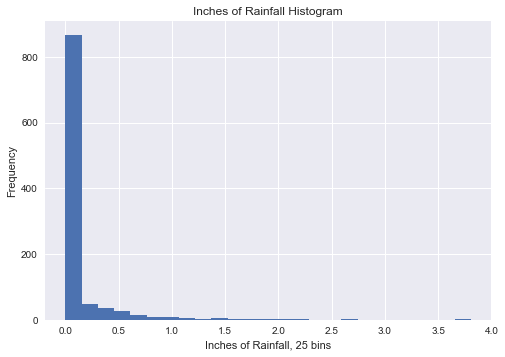

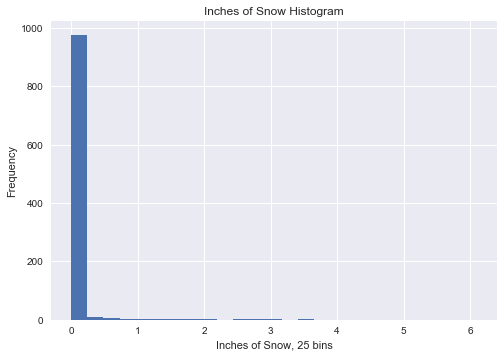

In [448]:
weather_df['PRCP'].plot(kind='hist', bins=25)
_ = plt.title('Inches of Rainfall Histogram')
_ = plt.xlabel('Inches of Rainfall, 25 bins')
plt.show()
plt.figure(1)
weather_df['SNOW'].plot(kind='hist', bins=25)
_ = plt.title('Inches of Snow Histogram')
_ = plt.xlabel('Inches of Snow, 25 bins')
plt.show()

As expected, we have very few days with snow and a typically low amount of rain. Let's see how the rain days correlate with number of accidents.

In [449]:
len(weather_df) # missing some days
len(day_counts)

# make an identifier for an easy join
weather_df['IDENTIFIER'] = weather_df['DATE'].dt.strftime('%Y%m%d')

# create our data mart -- this also drops the days for which we don't have data.
df = weather_df[['IDENTIFIER', 'PRCP', 'SNOW']].merge(day_counts[['IDENTIFIER', 0]], on='IDENTIFIER').rename(columns={0:'NUM_ACCIDENTS'})
df.head()
df.describe()

1029

1096

,IDENTIFIER,PRCP,SNOW,NUM_ACCIDENTS
0,20160101,0.0,0.0,54
1,20160102,0.0,0.0,43
2,20160103,0.0,0.0,43
3,20160104,0.0,0.0,49
4,20160105,0.0,0.0,50


,PRCP,SNOW,NUM_ACCIDENTS
count,1029.000000,1029.000000,1029.000000
mean,0.107687,0.093878,40.217687
std,0.304989,0.519813,10.196286
min,0.000000,0.000000,6.000000
25%,0.000000,0.000000,34.000000
50%,0.000000,0.000000,39.000000
75%,0.050000,0.000000,46.000000
max,3.810000,6.100000,99.000000


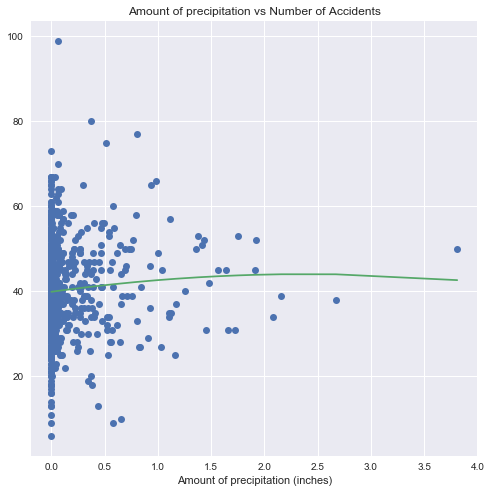

In [450]:
_ = plt.figure(1, figsize=(8,8))
_ = plt.plot(df['PRCP'], df['NUM_ACCIDENTS'], 'o')
utils.plot_trendline(df['PRCP'], df['NUM_ACCIDENTS'], 2)
_ = plt.title('Amount of precipitation vs Number of Accidents')
_ = plt.xlabel('Amount of precipitation (inches)')
plt.show()

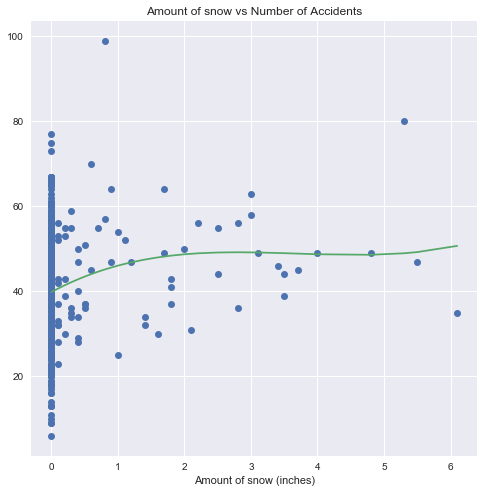

In [451]:
_ = plt.figure(1, figsize=(8,8))
_ = plt.plot(df['SNOW'], df['NUM_ACCIDENTS'], 'o')
utils.plot_trendline(df['SNOW'], df['NUM_ACCIDENTS'], 3)
_ = plt.title('Amount of snow vs Number of Accidents')
_ = plt.xlabel('Amount of snow (inches)')
plt.show()

In [452]:
df[['PRCP', 'NUM_ACCIDENTS']].corr()

,PRCP,NUM_ACCIDENTS
PRCP,1.000000,0.065599
NUM_ACCIDENTS,0.065599,1.000000


In [453]:
df[['SNOW', 'NUM_ACCIDENTS']].corr()

,SNOW,NUM_ACCIDENTS
SNOW,1.000000,0.140123
NUM_ACCIDENTS,0.140123,1.000000
